# 25. Denoising AutoEncoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import random
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Load MNIST Data

In [3]:
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [4]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=1,
                                          shuffle=False)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

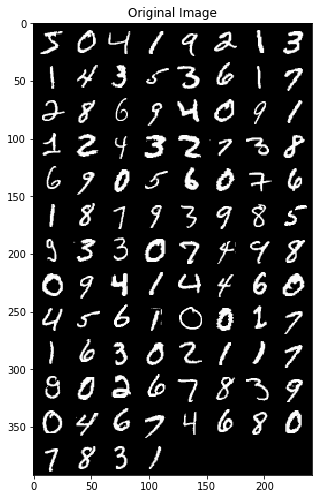

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Original Image")

In [7]:
print(images.size())

noise = torch.randn(images.size())*0.3
print(noise.size())

noise_X = images + noise
print(noise_X.size())

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


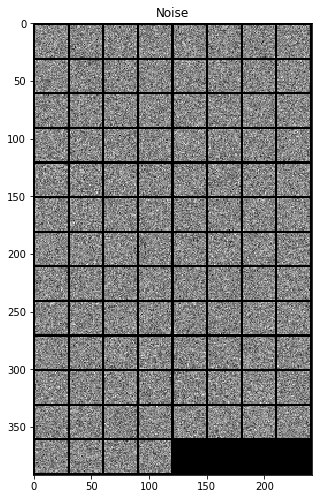

In [8]:
imshow(torchvision.utils.make_grid(noise, normalize=True), "Noise")

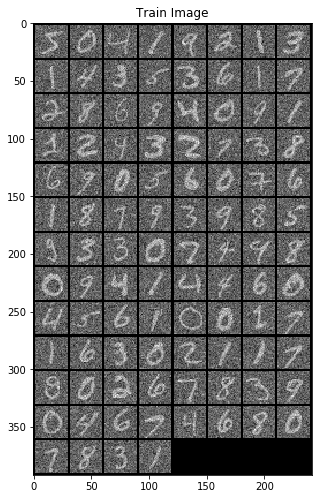

In [9]:
imshow(torchvision.utils.make_grid(noise_X, normalize=True), "Train Image")

## Define Model

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16,32,5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2) #64*4*4
        )
        
    def forward(self, x):
        z = self.encoder(x)
        
        return z

In [11]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,5,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32,16,4,stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.ConvTranspose2d(16,1,4,stride=2,padding=1),
            nn.ReLU()
        )
        
    def forward(self, z):
        out = self.decoder(z)
        out = out.view(-1,1,28,28)
        
        return out

In [12]:
E = Encoder().cuda()
D = Decoder().cuda()

## Training

In [13]:
loss = nn.MSELoss()
optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()), lr=0.001)

In [14]:
num_epochs = 5

for epoch in range(num_epochs):
    
    total_batch = len(mnist_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        
        noise = (torch.randn(X.size())*0.3).cuda()
        
        noise_X = X + noise
        
        pred = D(E(noise_X))     # noised image 학습
        cost = loss(pred, X)     # cost는 original image와 비교
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) == total_batch:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'%(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    
print("Learning Finished!")

Epoch [1/5], lter [600/600] Loss: 0.0237
Epoch [2/5], lter [600/600] Loss: 0.0194
Epoch [3/5], lter [600/600] Loss: 0.0176
Epoch [4/5], lter [600/600] Loss: 0.0163
Epoch [5/5], lter [600/600] Loss: 0.0151
Learning Finished!


## Test

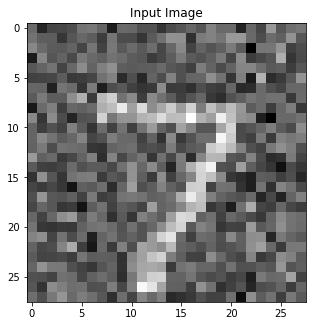

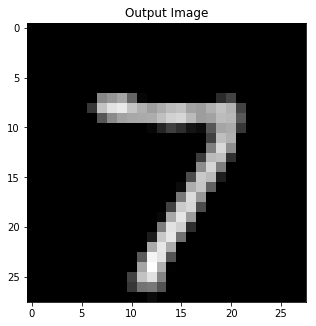

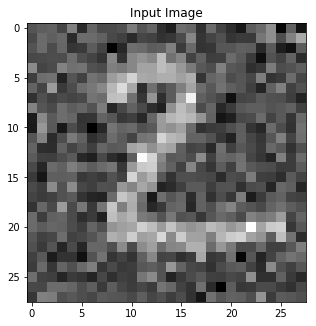

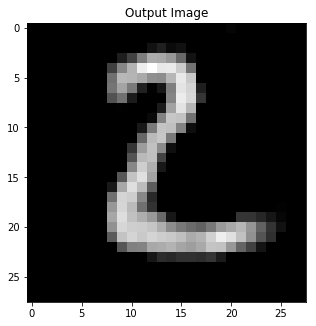

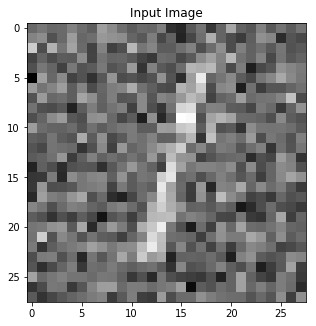

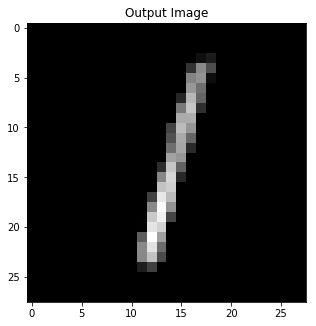

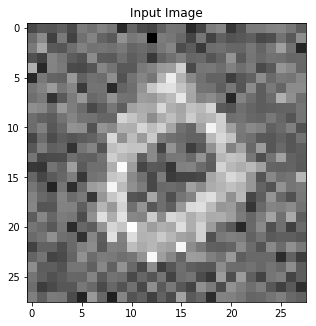

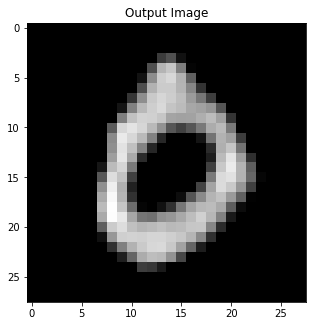

In [15]:
E.eval()
D.eval()

for n, (images, labels) in enumerate(test_loader):
    
    images = images.cuda()
    
    noise = (torch.randn(images.size())*0.3).cuda()
    
    noise_images = images + noise
    
    imshow(torchvision.utils.make_grid(noise_images.data.cpu(), normalize=True), "Input Image")
    
    noise_images = noise_images.view(-1, 1, 28, 28)
    
    outputs = D(E(noise_images))
    outputs = outputs.view(-1, 1, 28, 28)
    
    imshow(torchvision.utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")
    
    if n > 2 : break